In [1]:
import gradio as gr
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer
import torch

# Load models
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

explainer = LimeTextExplainer(class_names=["NEGATIVE", "POSITIVE"])

def analyze(text, explain):
    outputs = {}

    # Sentiment
    try:
        sentiment = sentiment_pipeline(text)[0]
        outputs["Sentiment"] = f"{sentiment['label']} ({sentiment['score']:.2f})"
    except Exception as e:
        outputs["Sentiment"] = f"Error: {str(e)}"

    # NER
    try:
        ents = ner_pipeline(text)
        if ents:
            ner_out = "\n".join([f"{e['word']} → {e['entity_group']} ({e['score']:.2f})" for e in ents])
        else:
            ner_out = "No entities found."
        outputs["NER"] = ner_out
    except Exception as e:
        outputs["NER"] = f"Error: {str(e)}"

    # LIME
    if explain:
        try:
            def predict_proba(texts):
                inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
                with torch.no_grad():
                    outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1).detach().numpy()
                return probs

            exp = explainer.explain_instance(text, predict_proba, num_features=4)
            lime_result = "\n".join([f"{word} → {weight:.2f}" for word, weight in exp.as_list()])
            outputs["LIME"] = lime_result
        except Exception as e:
            outputs["LIME"] = f"Error: {str(e)}"
    else:
        outputs["LIME"] = "LIME explanation skipped."

    return outputs["Sentiment"], outputs["NER"], outputs["LIME"]

gr.Interface(
    fn=analyze,
    inputs=[
        gr.Textbox(lines=4, label="Enter text"),
        gr.Checkbox(label="Run LIME Explanation (slower on CPU)", value=False)
    ],
    outputs=[
        gr.Textbox(label="Sentiment"),
        gr.Textbox(label="Named Entities"),
        gr.Textbox(label="LIME Explanation")
    ],
    title="🧠 NLP Chatbot: Sentiment, NER, LIME",
    description="Fine-tuned Transformers with optional LIME-based explainability."
).launch()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initia

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://968980d193fae7012d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [2]:
import traceback

def chatbot(user_input, history):
    history = history or []
    bot_response = ""

    try:
        # Sentiment
        sentiment = sentiment_pipeline(user_input)[0]
        bot_response += f"🟡 **Sentiment:** `{sentiment['label']}` ({sentiment['score']:.2f})\n\n"

        # NER
        ents = ner_pipeline(user_input)
        if ents:
            bot_response += "**🧠 Named Entities:**\n"
            for e in ents:
                bot_response += f"- `{e['word']}` → **{e['entity_group']}** ({e['score']:.2f})\n"
        else:
            bot_response += "No named entities found.\n\n"

        # LIME
        def predict_proba(texts):
            inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
            with torch.no_grad():
                outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1).detach().numpy()
            return probs

        exp = explainer.explain_instance(user_input, predict_proba, num_features=4)
        bot_response += "\n🧪 **LIME Explanation:**\n"
        for word, weight in exp.as_list():
            bot_response += f"- `{word}` → weight = `{weight:.2f}`\n"

    except Exception:
        err = traceback.format_exc()
        bot_response = f"⚠️ **Error occurred:**\n```\n{err}\n```"

    history.append((user_input, bot_response))
    return history, history


In [3]:
import gradio as gr
from transformers import pipeline

# Load sentiment and NER models
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")

# Simplified chatbot function — no LIME, no state
def debug_bot(text):
    try:
        sentiment = sentiment_pipeline(text)[0]
        ents = ner_pipeline(text)

        output = f"🟡 Sentiment: **{sentiment['label']}** ({sentiment['score']:.2f})\n\n"
        if ents:
            output += "**🧠 Named Entities:**\n"
            for e in ents:
                output += f"- `{e['word']}` → **{e['entity_group']}** ({e['score']:.2f})\n"
        else:
            output += "No named entities found."

        return output

    except Exception as e:
        return f"❌ Error: {str(e)}"

# Interface
gr.Interface(fn=debug_bot, inputs="text", outputs="markdown", title="Test: BERT Sentiment + NER").launch()


Device set to use cpu
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f124a1bd5b964f409c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [4]:
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

# Load reviews and labels
docs = [" ".join(movie_reviews.words(fileid)) for fileid in movie_reviews.fileids()]
labels = [fileid.split('/')[0] for fileid in movie_reviews.fileids()]  # pos/neg

print(f"Loaded {len(docs)} reviews. Example:\n\n{docs[0][:500]}")


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Loaded 2000 reviews. Example:

plot : two teen couples go to a church party , drink and then drive . they get into an accident . one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . what ' s the deal ? watch the movie and " sorta " find out . . . critique : a mind - fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . which is what makes this review an even harder one to write , since i generally applaud films which attempt t


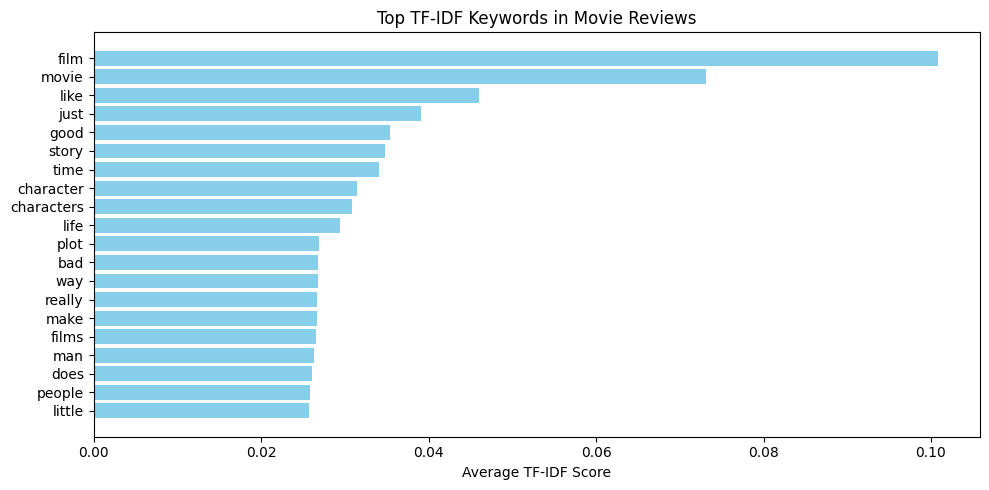

In [5]:
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Vectorize reviews
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

# Average TF-IDF scores across all documents
avg_scores = tfidf_matrix.mean(axis=0).A1
tfidf_df = pd.DataFrame({'term': feature_names, 'score': avg_scores})
top_n = 20
top_keywords = tfidf_df.sort_values(by='score', ascending=False).head(top_n)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(top_keywords['term'][::-1], top_keywords['score'][::-1], color='skyblue')
plt.title("Top TF-IDF Keywords in Movie Reviews")
plt.xlabel("Average TF-IDF Score")
plt.tight_layout()
plt.show()


In [7]:
!pip install gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab') # Add this line to download the required resource

# Tokenize all reviews
tokenized_reviews = [word_tokenize(doc.lower()) for doc in docs]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)
print("✅ Word2Vec model trained.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ Word2Vec model trained.


In [8]:
# Input any word to find top 10 similar words
query = "love"
if query in w2v_model.wv:
    similar_words = w2v_model.wv.most_similar(query, topn=10)
    print(f"\n🔁 Words similar to '{query}':\n")
    for word, score in similar_words:
        print(f"{word:15} → {score:.2f}")
else:
    print(f"'{query}' not in vocabulary.")



🔁 Words similar to 'love':

hope            → 0.60
lost            → 0.59
living          → 0.57
kiss            → 0.57
god             → 0.56
family          → 0.55
kinfolk         → 0.55
hate            → 0.55
dead            → 0.55
replacements    → 0.55


In [9]:
import gradio as gr

# Define prediction function
def find_similar(word):
    word = word.strip().lower()
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=10)
        output = f"🔁 **Words similar to** `{word}`:\n\n"
        for w, score in similar:
            output += f"- `{w}` → {score:.2f}\n"
        return output
    else:
        return f"⚠️ `{word}` not in vocabulary. Try another word."

# Gradio app
gr.Interface(
    fn=find_similar,
    inputs=gr.Textbox(label="Enter a word (e.g. love, horror, great)"),
    outputs=gr.Markdown(),
    title="🔍 Word2Vec Explorer",
    description="Enter any word from the movie reviews dataset to see similar words using Gensim Word2Vec."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://253b56df6739b076bb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
